<a href="https://colab.research.google.com/github/akhil7philip/Agriculture/blob/main/Agri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Packages**

In [2]:
!pip install -q catboost

     |████████████████████████████████| 76.1 MB 1.3 MB/s 


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn import svm 
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier 
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder 
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

In [5]:
from lightgbm import LGBMClassifier 
from catboost import CatBoostClassifier 
from xgboost import XGBClassifier

In [6]:
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = 'all' 

pd.set_option('display.max_colwidth', -1) 

import warnings 
warnings.simplefilter('ignore')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


# **Load Files**

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

# https://neptune.ai/blog/google-colab-dealing-with-files

Mounted at /content/gdrive


In [8]:
#from google.colab import files 
#files.upload()

#!unzip -q <file.zip>

In [9]:
#train = pd.read_csv('/train.csv')
#test = pd.read_csv('/test.csv')
#submission = pd.read_csv('/sample_submission.csv')

In [10]:
train = pd.read_csv('/content/gdrive/MyDrive/projects/Agri/train.csv')
test = pd.read_csv('/content/gdrive/MyDrive/projects/Agri/test.csv')
submission = pd.read_csv('/content/gdrive/MyDrive/projects/Agri/sample_submission.csv')

# **Guide**

* Understand problem statement well; if not given, identify problem statement (objective of problem)
* Remove ID column from dataset; don't want model to be trained based on that
* Hypothesis generation based on problem; like is young more likely to deposit more than old 
* EDA: summarise train, target distribution, null values, unique values, categorical (pie, bar) and numerical (box, hist) values visualisation, bivariate and multivariate analysis, heat maps to find correlation; look into pandas-profiling; Advanced steps like Feature Importance Scores
* Metrics: Accuracy score
* Build a baseline model to get basic score
* Steps to build model: 
    * Concatenate train and test sets, as data preprocessing should be done on both train and test sets together; 
    * Convert all categorical variables into numbers (OneHot Encoding); 
    * Fill null values; 
    * Split dataset into train and test sets; 
    * Split train set into train and validation sets; 
    * Fit a classification model on train, check result on validation set; 
    * Predict test set

# **EDA**

## Summarise data

In [107]:
print(f'Train contains {train.shape[0]} samples and {train.shape[1]} variables')
print(f'Test contains {test.shape[0]} samples and {test.shape[1]} variables')

Train contains 88858 samples and 10 variables
Test contains 59310 samples and 9 variables


In [108]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88858 entries, 0 to 88857
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       88858 non-null  object 
 1   Estimated_Insects_Count  88858 non-null  int64  
 2   Crop_Type                88858 non-null  int64  
 3   Soil_Type                88858 non-null  int64  
 4   Pesticide_Use_Category   88858 non-null  int64  
 5   Number_Doses_Week        88858 non-null  int64  
 6   Number_Weeks_Used        79858 non-null  float64
 7   Number_Weeks_Quit        88858 non-null  int64  
 8   Season                   88858 non-null  int64  
 9   Crop_Damage              88858 non-null  int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 6.8+ MB


##Target Distribution

In [109]:
#0=alive, 1=damage due to other causes, 2=damage due to pesticides
train['Crop_Damage'].value_counts(normalize=True)

0    0.835468
1    0.138502
2    0.026030
Name: Crop_Damage, dtype: float64

<function matplotlib.pyplot.show>

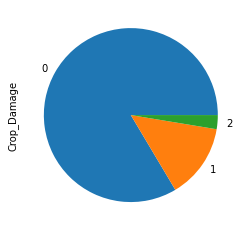

In [110]:
train['Crop_Damage'].value_counts().plot(kind='pie')
plt.show

##Null values

In [111]:
# percentage of null values in each column
(train.isnull().sum()/train.shape[0]*100).sort_values(ascending=False)

Number_Weeks_Used          10.12852
ID                         0.00000 
Estimated_Insects_Count    0.00000 
Crop_Type                  0.00000 
Soil_Type                  0.00000 
Pesticide_Use_Category     0.00000 
Number_Doses_Week          0.00000 
Number_Weeks_Quit          0.00000 
Season                     0.00000 
Crop_Damage                0.00000 
dtype: float64

*we see that only 'Number_Weeks_Used' has null values*

##Unique values

In [112]:
train.nunique()

ID                         88858
Estimated_Insects_Count    71   
Crop_Type                  2    
Soil_Type                  2    
Pesticide_Use_Category     3    
Number_Doses_Week          20   
Number_Weeks_Used          64   
Number_Weeks_Quit          51   
Season                     3    
Crop_Damage                3    
dtype: int64

## Analyse each variable and relationships

### Intro

**Data types**: Nominal data, Categorical data

**Types of Analysis**: Univariate and Multi-variate


In [113]:
columns = [col for col in train.columns if col not in ['ID','Crop_Damage']]
cat_cols = ['Crop_Type', 'Soil_Type', 'Pesticide_Use_Category', 'Season']
num_cols = [cols for cols in columns if cols not in cat_cols]
num_cols

['Estimated_Insects_Count',
 'Number_Doses_Week',
 'Number_Weeks_Used',
 'Number_Weeks_Quit']

###Dealing with categorical data

In [114]:
for col in cat_cols:
     print((train[col].value_counts()/train.shape[0]*100).sort_values(ascending=False))

0    71.562493
1    28.437507
Name: Crop_Type, dtype: float64
0    54.15832
1    45.84168
Name: Soil_Type, dtype: float64
2    71.697540
3    27.360508
1    0.941952 
Name: Pesticide_Use_Category, dtype: float64
2    49.753539
1    30.275271
3    19.971190
Name: Season, dtype: float64


Text(0.5, 1.0, 'Crop_Type')

Text(0.5, 1.0, 'Soil_Type')

Text(0.5, 1.0, 'Pesticide_Use_Category')

Text(0.5, 1.0, 'Season')

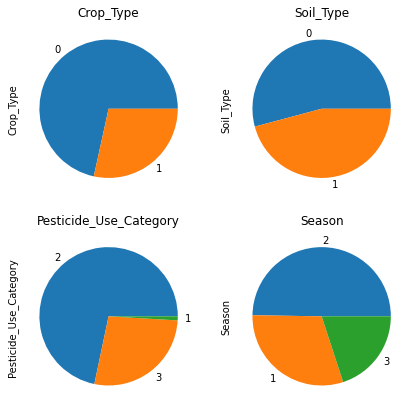

In [115]:
 #plt.figure(figsize=(10,20))
 
 for i,col in enumerate(cat_cols):
     plt.subplot(2,2,i+1)
     train[col].value_counts().plot(kind='pie', figsize=(7,7))
     plt.title(col)

# Pesticide_Use_Category : 1-Never, 2-Previously Used, 3-Currently Using

Text(0.5, 1.0, 'Crop_Type')

Text(0.5, 1.0, 'Soil_Type')

Text(0.5, 1.0, 'Pesticide_Use_Category')

Text(0.5, 1.0, 'Season')

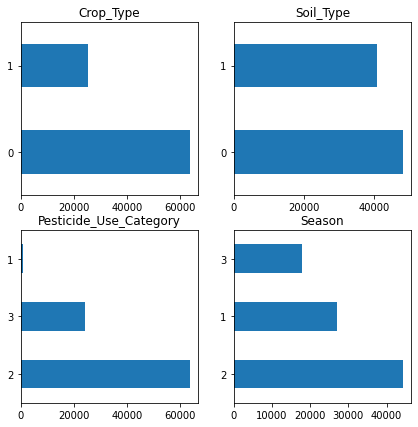

In [116]:
 #plt.figure(figsize=(10,20))
 
 for i,col in enumerate(cat_cols):
     plt.subplot(2,2,i+1)
     train[col].value_counts().plot(kind='barh', figsize=(7,7))
     plt.title(col)

# Pesticide_Use_Category : 1-Never, 2-Previously Used, 3-Currently Using

### Bivariate Analysis

In [117]:
for col in cat_cols:
     print(col, train[col].unique())

Crop_Type [1 0]
Soil_Type [0 1]
Pesticide_Use_Category [1 3 2]
Season [1 2 3]


In [118]:
for i,col in enumerate(cat_cols):
    print(train[[col,'Crop_Damage']].value_counts(normalize=True,sort=False).reset_index().rename(columns={0:'counts'}))

   Crop_Type  Crop_Damage    counts
0  0          0            0.593959
1  0          1            0.103581
2  0          2            0.018085
3  1          0            0.241509
4  1          1            0.034921
5  1          2            0.007945
   Soil_Type  Crop_Damage    counts
0  0          0            0.448367
1  0          1            0.078248
2  0          2            0.014968
3  1          0            0.387101
4  1          1            0.060253
5  1          2            0.011063
   Pesticide_Use_Category  Crop_Damage    counts
0  1                       0            0.001328
1  1                       1            0.006235
2  1                       2            0.001857
3  2                       0            0.641000
4  2                       1            0.068334
5  2                       2            0.007641
6  3                       0            0.193140
7  3                       1            0.063933
8  3                       2            0.016532
   Sea

**Inference: Pesticide Never used (1): 0.94% of total;**

**yet, Crop death due to pesticide (3): 1.65% for pesticide currently using category(1)**

<Figure size 2880x720 with 0 Axes>

Text(0.5, 1.0, 'Crop_Type and Crop_Damage')

Text(0.5, 1.0, 'Soil_Type and Crop_Damage')

Text(0.5, 1.0, 'Pesticide_Use_Category and Crop_Damage')

Text(0.5, 1.0, 'Season and Crop_Damage')

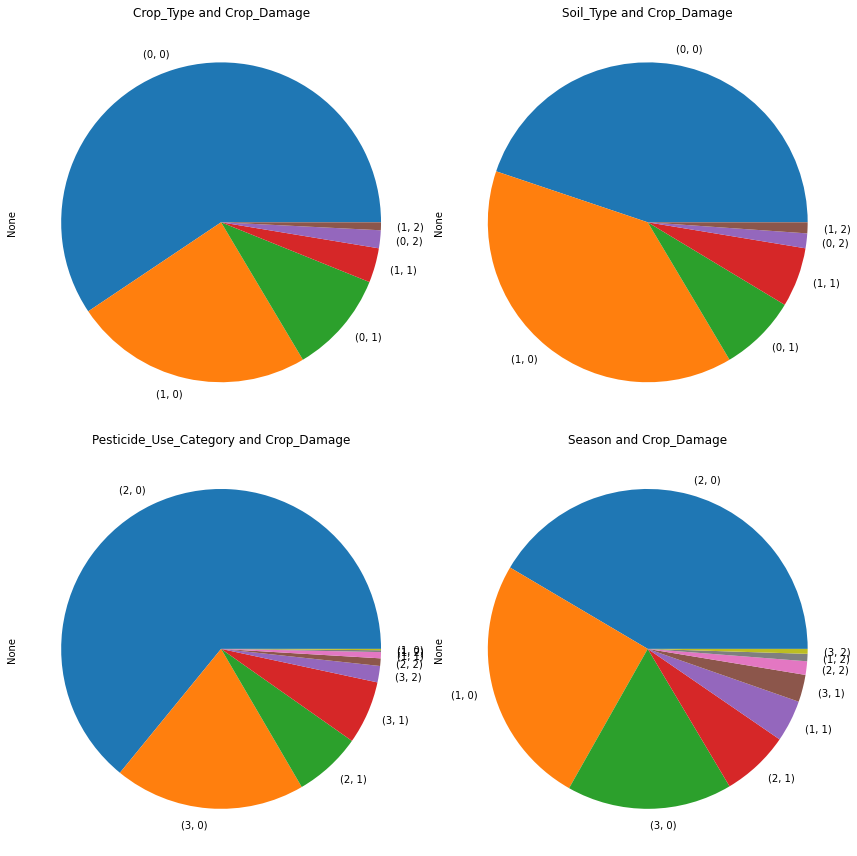

In [119]:
plt.figure(figsize=(40,10))
 
for i,col in enumerate(cat_cols):
    plt.subplot(2,2,i+1)
    train[[col,'Crop_Damage']].value_counts().plot(kind='pie', figsize=(12,12))
    plt.title(col + ' and Crop_Damage')
    #plt.show()

plt.tight_layout()
# Pesticide_Use_Category : 1-Never, 2-Previously Used, 3-Currently Using
# Crop_Damage 0=alive, 1=damage due to other causes, 2=damage due to pesticides

Text(0.5, 1.0, 'Crop_Type and Crop_Damage')

Text(0.5, 1.0, 'Soil_Type and Crop_Damage')

Text(0.5, 1.0, 'Pesticide_Use_Category and Crop_Damage')

Text(0.5, 1.0, 'Season and Crop_Damage')

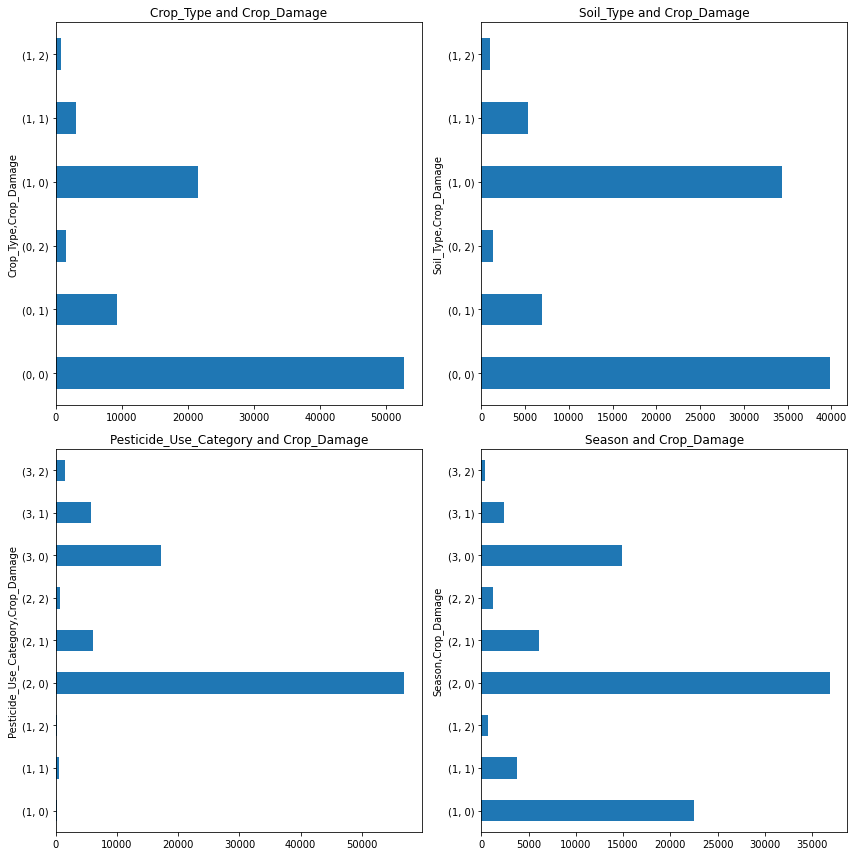

In [120]:
#plt.figure(figsize=(50,10))

for i,col in enumerate(cat_cols):
    plt.subplot(2,2,i+1)
    df = train[[col,'Crop_Damage']].value_counts(sort=False)
    #train[[col,'Crop_Damage']].value_counts()
    df.plot(kind='barh', figsize=(12,12))
    plt.title(col + ' and Crop_Damage')

plt.tight_layout()
# Pesticide_Use_Category : 1-Never, 2-Previously Used, 3-Currently Using
# Crop_Damage 0=alive, 1=damage due to other causes, 2=damage due to pesticides

In [121]:
#df.value_counts?

<Figure size 720x720 with 0 Axes>

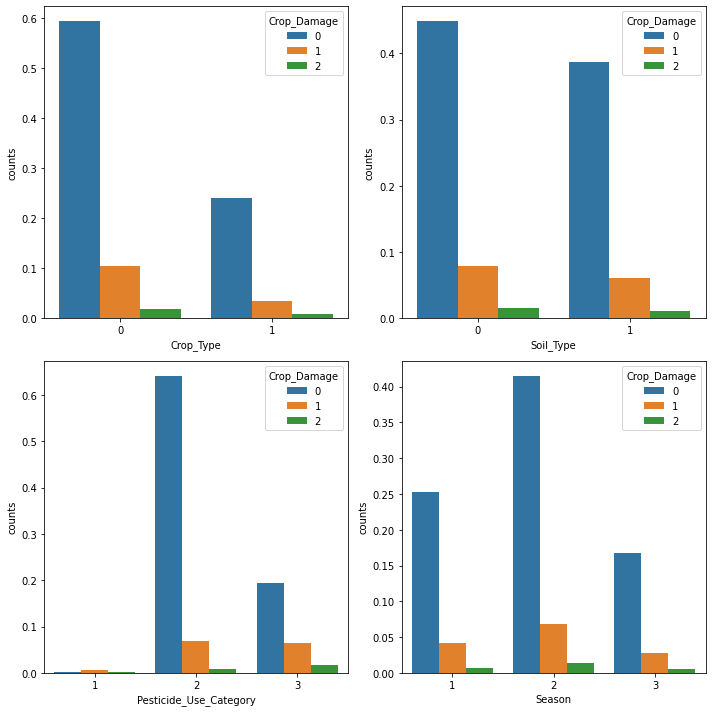

In [122]:
plt.figure(figsize=(10,10))

for i, col in enumerate(cat_cols): 
    plt.subplot(2,2,i+1)
    df = train[[col,'Crop_Damage']].value_counts(normalize=True,sort=False).reset_index().rename(columns={0:'counts'})
    #print(df)
    sns.barplot(x=col, y='counts', data=df, hue='Crop_Damage')

plt.tight_layout()

In [133]:
for i, c in enumerate(cat_cols): 
    fltr0 = train['Crop_Damage'] == 0
    fltr1 = train['Crop_Damage'] == 1
    fltr2 = train['Crop_Damage'] == 2
    
    vc_0 = train[fltr0][c].value_counts(normalize=True).reset_index().rename({'index': c, c: 'count'}, axis=1)
    vc_1 = train[fltr1][c].value_counts(normalize=True).reset_index().rename({'index': c, c: 'count'}, axis=1)
    vc_2 = train[fltr2][c].value_counts(normalize=True).reset_index().rename({'index': c, c: 'count'}, axis=1)

    vc_0['Crop_Damage'] = 0
    vc_1['Crop_Damage'] = 1
    vc_2['Crop_Damage'] = 2
    
    df = pd.concat([vc_0, vc_1, vc_2]).reset_index(drop = True)
    print(df.head())

   Crop_Type     count  Crop_Damage
0  0          0.710930  0          
1  1          0.289070  0          
2  0          0.747867  1          
3  1          0.252133  1          
4  0          0.694769  2          
   Soil_Type     count  Crop_Damage
0  0          0.536666  0          
1  1          0.463334  0          
2  0          0.564963  1          
3  1          0.435037  1          
4  0          0.575011  2          
   Pesticide_Use_Category     count  Crop_Damage
0  2                       0.767235  0          
1  3                       0.231175  0          
2  1                       0.001589  0          
3  2                       0.493378  1          
4  3                       0.461607  1          
   Season     count  Crop_Damage
0  2       0.496794  0          
1  1       0.302985  0          
2  3       0.200221  0          
3  2       0.496872  1          
4  1       0.304542  1          


<Figure size 720x720 with 0 Axes>

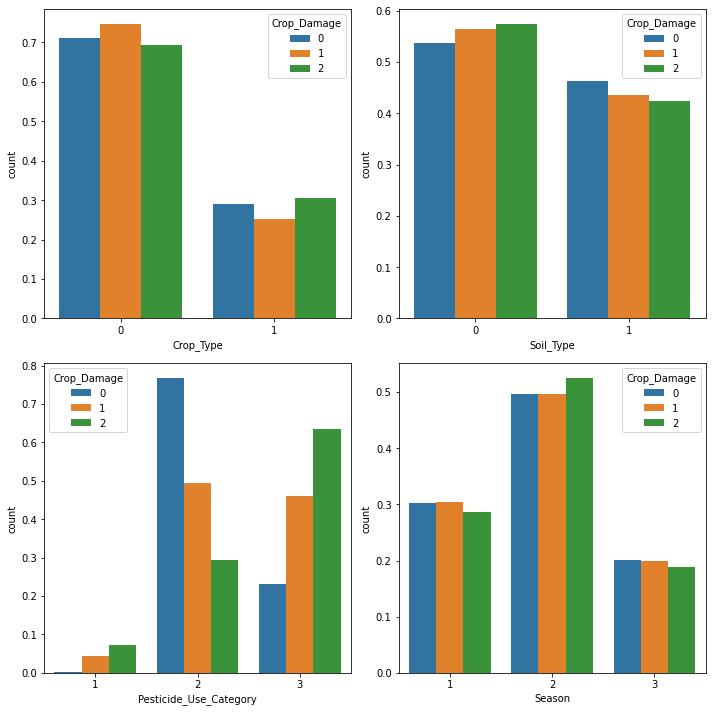

In [124]:
#fig, axes = plt.subplots(2,2,figsize=(10,10))
#axes = [ax for axes_row in axes for ax in axes_row]

plt.figure(figsize=(10,10))

for i, c in enumerate(cat_cols): 
    plt.subplot(2,2,i+1)
    fltr0 = train['Crop_Damage'] == 0
    fltr1 = train['Crop_Damage'] == 1
    fltr2 = train['Crop_Damage'] == 2
    
    vc_0 = train[fltr0][c].value_counts(normalize=True).reset_index().rename({'index': c, c: 'count'}, axis=1)
    vc_1 = train[fltr1][c].value_counts(normalize=True).reset_index().rename({'index': c, c: 'count'}, axis=1)
    vc_2 = train[fltr2][c].value_counts(normalize=True).reset_index().rename({'index': c, c: 'count'}, axis=1)

    vc_0['Crop_Damage'] = 0
    vc_1['Crop_Damage'] = 1
    vc_2['Crop_Damage'] = 2
    
    df = pd.concat([vc_0, vc_1, vc_2]).reset_index(drop = True) 
    #print(df)
    sns.barplot(x=c, y='count', data=df, hue='Crop_Damage')#, ax=axes[i]) 

plt.tight_layout() 

**Inference:** Crop_Type, Soil_Type, Season don't make such difference; except Pesticide_Use_Category

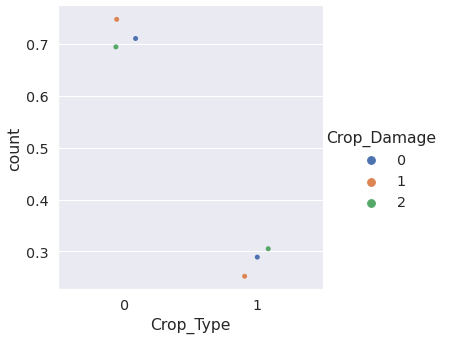

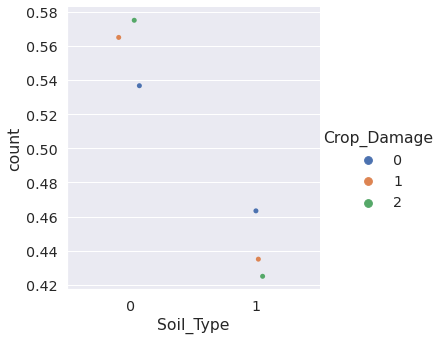

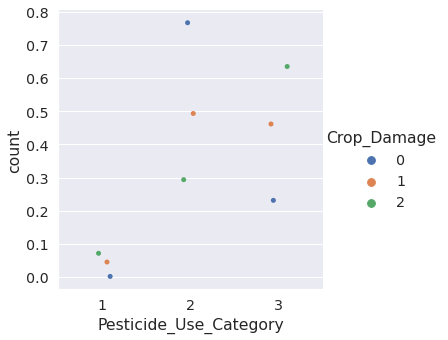

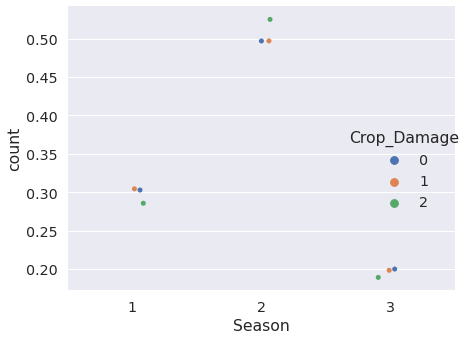

In [136]:
#axes = [ax for axes_row in axes for ax in axes_row]
#plt.subplots(2,2,figsize=(10,10))

for i, c in enumerate(train[cat_cols]): 
    fltr0 = train['Crop_Damage'] == 0
    fltr1 = train['Crop_Damage'] == 1
    fltr2 = train['Crop_Damage'] == 2
    
    vc_0 = train[fltr0][c].value_counts(normalize=True).reset_index().rename({'index': c, c: 'count'}, axis=1)
    vc_1 = train[fltr1][c].value_counts(normalize=True).reset_index().rename({'index': c, c: 'count'}, axis=1)
    vc_2 = train[fltr2][c].value_counts(normalize=True).reset_index().rename({'index': c, c: 'count'}, axis=1)

    vc_0['Crop_Damage'] = 0
    vc_1['Crop_Damage'] = 1
    vc_2['Crop_Damage'] = 2
    
    #plt.subplot(2,2,i+1)
    df = pd.concat([vc_0, vc_1, vc_2]).reset_index(drop = True) 
    #print(df)
    sns.catplot(x=c, y='count', data=df, hue='Crop_Damage') 

plt.tight_layout()

###Dealing with Numerical data

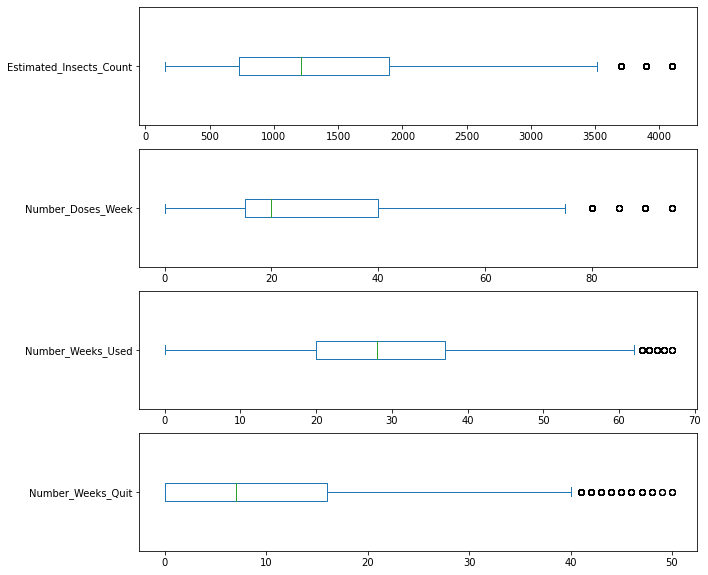

In [126]:
for i,col in enumerate(num_cols):
     plt.subplot(4,1,i+1)
     train[col].plot(kind='box', figsize=(10,10), vert=False)
     #plt.title(col)

Text(0.5, 1.0, 'Estimated_Insects_Count')

Text(0.5, 1.0, 'Number_Doses_Week')

Text(0.5, 1.0, 'Number_Weeks_Used')

Text(0.5, 1.0, 'Number_Weeks_Quit')

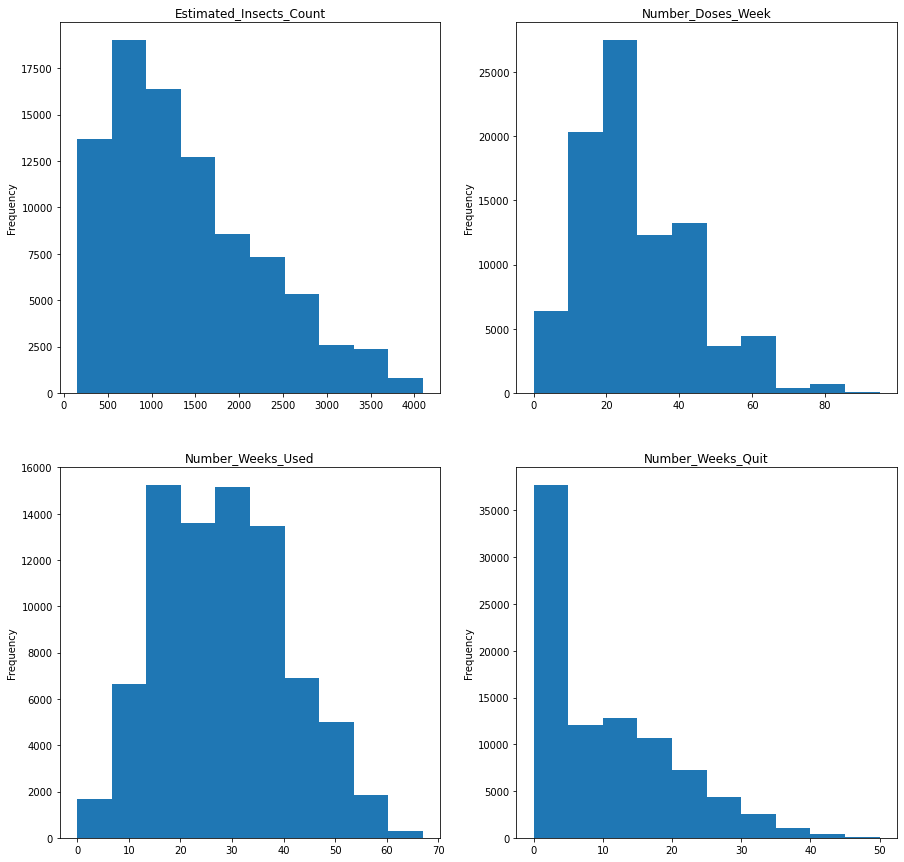

In [127]:
for i,col in enumerate(num_cols):
     plt.subplot(2,2,i+1)
     train[col].plot(kind='hist', figsize=(15,15))
     plt.title(col)

###Bivariate Analysis - Numerical datatypes

<Figure size 864x864 with 0 Axes>

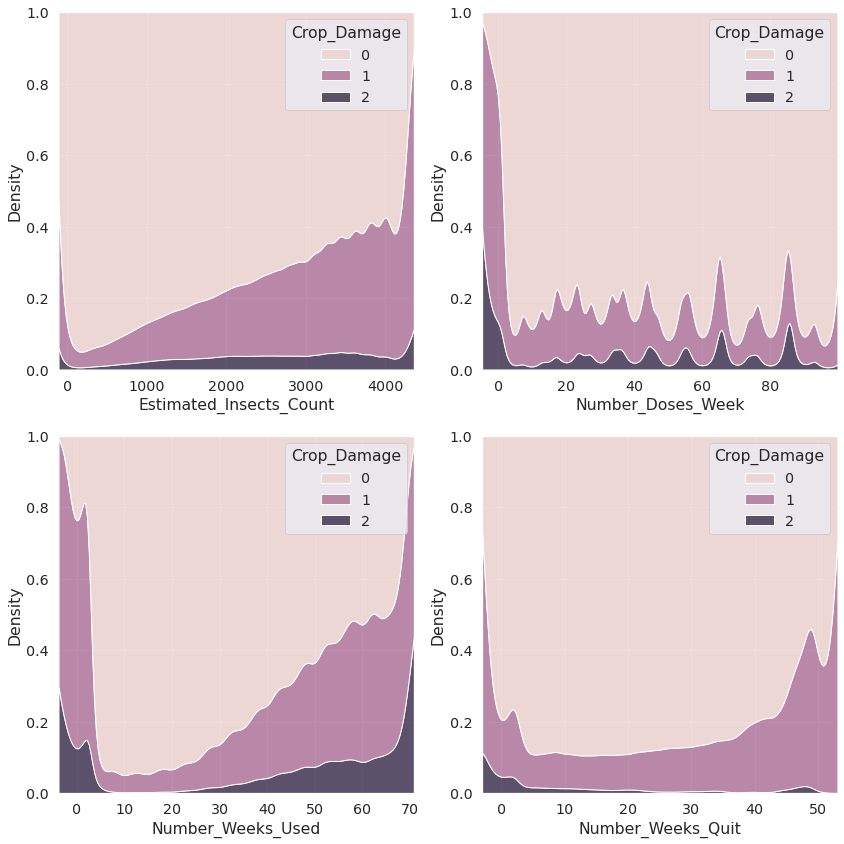

In [128]:
plt.figure(figsize=(12,12))
sns.set(font_scale=1.3)

for i,col in enumerate(num_cols): 
    plt.subplot(2,2,i+1)
    sns.kdeplot(data=train, x=col, hue='Crop_Damage', multiple='fill')

plt.tight_layout()
plt.show()
# Crop_Damage 0=alive, 1=damage due to other causes, 2=damage due to pesticides

###Bivariate Anaylysis - Median
Due to many outliers, we also look at *Median* value

In [129]:
for i,col in enumerate(num_cols): 
    print(train.groupby('Crop_Damage')[col].median())
# Crop_Damage 0=alive, 1=damage due to other causes, 2=damage due to pesticides

Crop_Damage
0    1132.0
1    1678.0
2    1576.0
Name: Estimated_Insects_Count, dtype: float64
Crop_Damage
0    20.0
1    20.0
2    20.0
Name: Number_Doses_Week, dtype: float64
Crop_Damage
0    26.0
1    36.0
2    40.0
Name: Number_Weeks_Used, dtype: float64
Crop_Damage
0    8.0
1    0.0
2    0.0
Name: Number_Weeks_Quit, dtype: float64


In [130]:
#train.groupby?

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Estimated_Insects_Count')

Text(0.5, 1.0, 'Number_Doses_Week')

Text(0.5, 1.0, 'Number_Weeks_Used')

Text(0.5, 1.0, 'Number_Weeks_Quit')

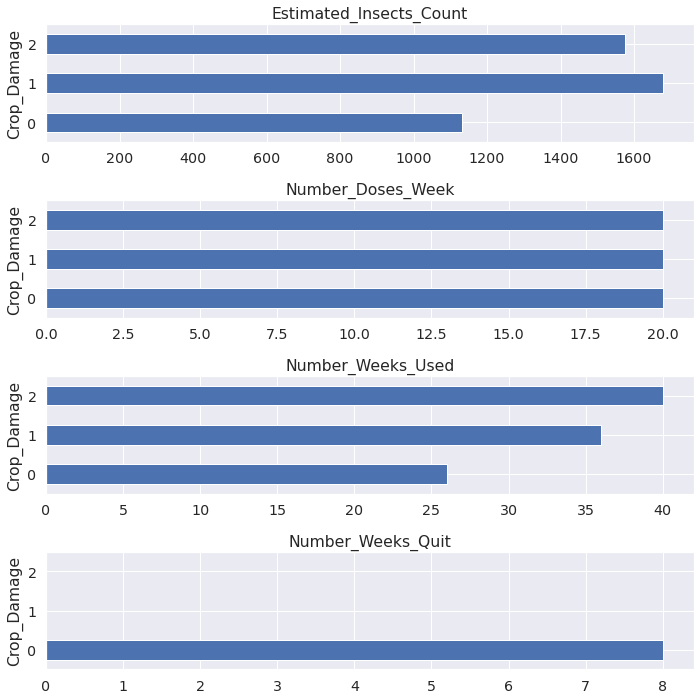

In [131]:
plt.figure(figsize=(10,10))
sns.set(font_scale=1.3)

for i,col in enumerate(num_cols): 
    plt.subplot(4,1,i+1)
    train.groupby('Crop_Damage')[col].median().plot(kind='barh')
    plt.title(col)

plt.tight_layout()
# Crop_Damage 0=alive, 1=damage due to other causes, 2=damage due to pesticides

### Heatmap

<Figure size 1008x576 with 0 Axes>

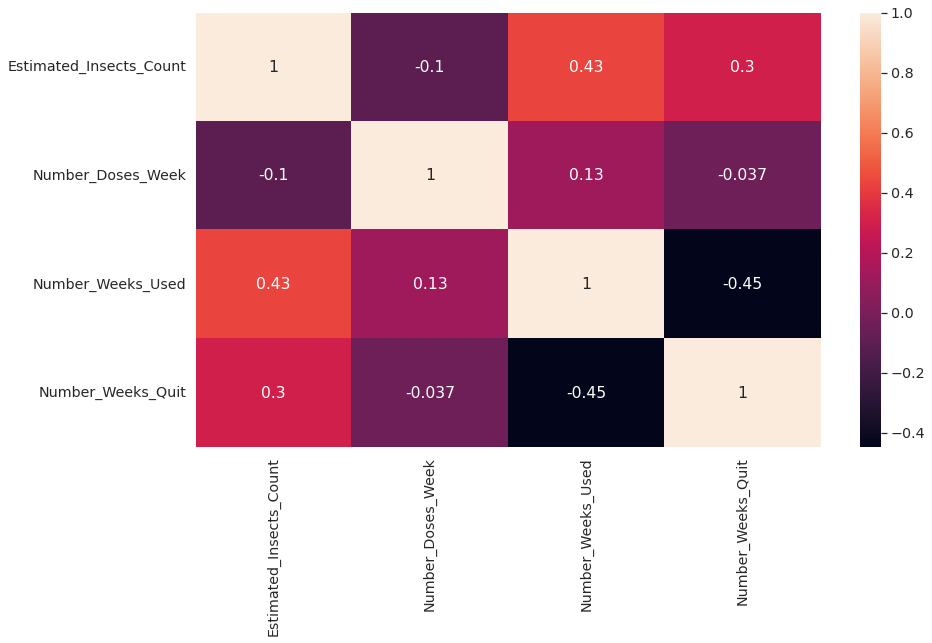

In [132]:
plt.figure(figsize=(14,8)) 
sns.heatmap(train[num_cols].corr(), annot=True)
plt.show()

Correlation between Number_Weeks_Quit, Number_Weeks_Used, Number_Weeks_Used and Estimated_Insects_Count, Number_Weeks_Quit and Estimated_Insects_Count

# **Metrics**

##Baseline model

###Helper function

In [26]:
def download_preds(preds_test, file_name = 'submission.csv'): 
    
    submission['Crop_Damage'] = preds_test 
    
    submission.to_csv(file_name, index=False) 
    
    from google.colab import files 
    files.download(file_name)


### Model A (Predicting all instances as 0 based on Target Distribution)

In [27]:
#0=alive, 1=damage due to other causes, 2=damage due to pesticides
train['Crop_Damage'].value_counts(normalize=True)

0    0.835468
1    0.138502
2    0.026030
Name: Crop_Damage, dtype: float64

In [28]:
y_pred = np.zeros(len(train))
y_test = train['Crop_Damage']

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='micro')

print(f'Accuracy score: {accuracy}')
print(f'F1 score: {f1}')

Accuracy score: 0.8354678250692116
F1 score: 0.8354678250692116


In [29]:
y_pred_test = np.zeros(len(test))

In [30]:
#download_preds(y_pred_test)

### Model B - Random predictions

In [31]:
np.random.seed(1)

y_pred = np.random.choice([0,1,2], size=len(train)) 
f1_score(y_test, y_pred, average='micro')

0.33567039546242317

In [32]:
np.random.seed(1)

y_pred_test = np.random.choice([0,1,2], size=len(test)) 
#download_preds(y_pred_test)

## Classifying based on important features

In [33]:
def rule_based_clf(df): 
    pred = np.ones(len(df)) 
    rule #boolean_mask 
    pred[rule] = 0 
    return pred

In [34]:
#y_pred = rule_based_clf(train)
#f1_score(y_test, y_pred)

##Preprocessing Data

### 1. Concat data

In [12]:
df = pd.concat([train, test]).reset_index(drop=True)
df.shape

(148168, 10)

### 2. One Hot Encoding
Though keep an eye on number of features formed post that; shouldn't be too large (unnecessary in our case as Catgorical vales already numerical)

In [13]:
print('columns in df: {} \nno. of categorical columns: {} \ntotal no. of unique values: {}'.format(df.shape[1], len(cat_cols), sum(list(map(lambda x: df[x].nunique(),cat_cols)))))

columns in df: 10 
no. of categorical columns: 4 
total no. of unique values: 10


In [14]:
df = pd.get_dummies(df, columns=cat_cols)

In [15]:
#pd.get_dummies?

In [16]:
df.shape[1] # 10 + 10 - 4

16

In [17]:
df.shape

(148168, 16)

### 3. Fill null values 
We fill we large negative random value like -999 so that it remains on outlier; we could also drop such columns or give other values like mean, median

In [18]:
# percentage of null values in each column
(df.isnull().sum()/df.shape[0]*100).sort_values(ascending=False)

Crop_Damage                 40.028886
Number_Weeks_Used           10.051428
ID                          0.000000 
Estimated_Insects_Count     0.000000 
Number_Doses_Week           0.000000 
Number_Weeks_Quit           0.000000 
Crop_Type_0                 0.000000 
Crop_Type_1                 0.000000 
Soil_Type_0                 0.000000 
Soil_Type_1                 0.000000 
Pesticide_Use_Category_1    0.000000 
Pesticide_Use_Category_2    0.000000 
Pesticide_Use_Category_3    0.000000 
Season_1                    0.000000 
Season_2                    0.000000 
Season_3                    0.000000 
dtype: float64

In [19]:
df.fillna(-999, inplace=True)
df.isnull().sum()

ID                          0
Estimated_Insects_Count     0
Number_Doses_Week           0
Number_Weeks_Used           0
Number_Weeks_Quit           0
Crop_Damage                 0
Crop_Type_0                 0
Crop_Type_1                 0
Soil_Type_0                 0
Soil_Type_1                 0
Pesticide_Use_Category_1    0
Pesticide_Use_Category_2    0
Pesticide_Use_Category_3    0
Season_1                    0
Season_2                    0
Season_3                    0
dtype: int64

### 4. Split dataset into train and test data

In [20]:
df.shape

(148168, 16)

In [21]:
train_proc, test_proc = df[:train.shape[0]], df[train.shape[0]:]
features = [col for col in train_proc.columns if col not in ['ID','Crop_Damage']]

In [22]:
train_proc.shape, test_proc.shape

((88858, 16), (59310, 16))

### 5. Split train into train and val data

**Stratified Sampling** is necessary, since dataset is highly imbalanced. It ensures that the minority class is distributed proportionally among the two classes.

In [23]:
X = train_proc[features]
y = train_proc['Crop_Damage']

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)
X_test = test_proc[features]

## 6. Fit classification model on train, check on val data

#### 6A. Logistic Regression
need to normalise data

In [25]:
X_train.shape

(71086, 14)

In [26]:
sc = StandardScaler()
sc.fit(X_train)

X_train = sc.transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

StandardScaler()

In [27]:
X_train.shape

(71086, 14)

In [28]:
clf = LogisticRegression(random_state = 7) 
clf.fit(X_train, y_train.astype('int'))

LogisticRegression(random_state=7)

In [29]:
y_pred = clf.predict(X_val)

In [30]:
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='micro')

print(f'Accuracy score: {accuracy}')
print(f'F1 score: {f1}')

Accuracy score: 0.838116137744767
F1 score: 0.838116137744767


In [31]:
y_val[y_val>1].shape

(454,)

In [32]:
y_pred[y_pred>1].shape

(0,)

In [33]:
y_pred_test = clf.predict(X_test)
#download_preds(y_pred_test)

#### 6B. Decision Tree
Don't require data to be normalised

In [34]:
clf = DecisionTreeClassifier(random_state = 7)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)

DecisionTreeClassifier(random_state=7)

In [35]:
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='micro')

print(f'Accuracy score: {accuracy}')
print(f'F1 score: {f1}')

Accuracy score: 0.7519693900517668
F1 score: 0.7519693900517668


In [36]:
y_pred_test = clf.predict(X_test)
#download_preds(y_pred_test)

## Hyperparameter Tuning

In our decision tree model earlier, we did not change any of the parameters that were input to our model. However hyper-parameters and their values vary from dataset to dataset, and their optimal values have a large impact on the performance of our model.

To perform hyperparameter-tuning we specify a list of hyper-parameters to tune and their possible values.

For example:

max_depth in decision trees: [6, 9, 12, 15]
learning_rate in NN: [0.0001, 0.005, 0.01, 0.05]
etc.

### 1. Grid Search
try all possible combinations of hyperparameter values by trial and error

### 2. Random Search: 
run model fixed number of times, say 10, and return best hyper-parameter combination; saves more time

#### Decision Tree

In [37]:
#check parameters
#DecisionTreeClassifier

In [38]:
from sklearn.model_selection import RandomizedSearchCV

hyperparam_combs = {
    'max_depth': [4, 6, 8, 10, 12],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 10, 20, 30, 40],
    'max_features': [0.2, 0.4, 0.6, 0.8, 1],
    'max_leaf_nodes': [8, 16, 32, 64, 128],
    'class_weight': [{0: 1, 1: 1, 2: 1}, {0: 1, 1: 2, 2: 2}, {0: 1, 1: 3, 2: 3}, {0: 1, 1: 4, 2: 4}, {0: 1, 1: 5, 2: 5}]
}

clf = RandomizedSearchCV(DecisionTreeClassifier(),
                         hyperparam_combs,
                         scoring='accuracy',
                         random_state=1,
                         n_iter=50)

search = clf.fit(X, y)

search.best_params_

{'class_weight': {0: 1, 1: 1, 2: 1},
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 0.8,
 'max_leaf_nodes': 128,
 'min_samples_split': 2}

In [39]:
optimal_params = {'class_weight': {0: 1, 1: 1, 2: 1},
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 0.8,
 'max_leaf_nodes': 128,
 'min_samples_split': 2}

clf = DecisionTreeClassifier(random_state = 1, **optimal_params)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)

DecisionTreeClassifier(class_weight={0: 1, 1: 1, 2: 1}, criterion='entropy',
                       max_depth=10, max_features=0.8, max_leaf_nodes=128,
                       random_state=1)

In [40]:
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='micro')

print(f'Accuracy score: {accuracy}')
print(f'F1 score: {f1}')

Accuracy score: 0.8427301372946208
F1 score: 0.8427301372946208


In [41]:
y_pred_test = clf.predict(X_test)
#download_preds(y_pred_test)

#### Logistic Regression

In [42]:
1e-2

0.01

In [43]:
#LogisticRegression?

In [44]:
hyperparam_combs = {
    'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'tol' : [0.08, 0.06, 0.05, 0.04, 0.02],
    'C' : [1, 2, 3, 4, 5],
    'class_weight' : [{0: 1, 1: 1, 2: 1}, {0: 1, 1: 1, 2: 2}, {0: 1, 1: 2, 2: 1}, {0: 1, 1: 1, 2: 3}],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

clf = RandomizedSearchCV(LogisticRegression(),
                         hyperparam_combs,
                         scoring='accuracy',
                         random_state=7,
                         n_iter=15)

search = clf.fit(X_train, y_train)

search.best_params_

{'C': 2,
 'class_weight': {0: 1, 1: 1, 2: 2},
 'penalty': 'l2',
 'solver': 'liblinear',
 'tol': 0.05}

In [45]:
optimal_params = {'C': 4,
 'class_weight': {0: 1, 1: 1, 2: 1},
 'penalty': 'l1',
 'solver': 'saga',
 'tol': 0.08}

clf = LogisticRegression(random_state = 7, **optimal_params) 
clf.fit(X_train, y_train.astype('int'))

y_pred = clf.predict(X_val)

LogisticRegression(C=4, class_weight={0: 1, 1: 1, 2: 1}, penalty='l1',
                   random_state=7, solver='saga', tol=0.08)

In [46]:
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='micro')

print(f'Accuracy score: {accuracy}')
print(f'F1 score: {f1}')

Accuracy score: 0.8383412108935404
F1 score: 0.8383412108935404


In [47]:
y_pred[y_pred>1].shape

(0,)

In [48]:
y_pred_test = clf.predict(X_test)
#download_preds(y_pred_test)

## Validation Strategy:

### Stratified K-Fold Validation
Use this instead of regular K-Fold Cross Validation as dataset target values skewed

In [49]:
X = train_proc[features]
y = train_proc['Crop_Damage']

In [50]:
from sklearn.model_selection import StratifiedKFold

In [51]:
def run_clf_kfold(clf, train, test, features):

  N_SPLITS = 5

  oofs = np.zeros(len(train))
  preds = np.zeros((len(test),3))

  folds = StratifiedKFold(n_splits = N_SPLITS)

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train['Crop_Damage'])):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    ############# Get train, validation and test sets along with targets ################
  
    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], train['Crop_Damage'].iloc[trn_idx]

    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], train['Crop_Damage'].iloc[val_idx]

    ### Test Set
    X_test = test[features]

    ############# Scaling Data ################
    scaler = StandardScaler()
    scaler.fit(X_trn)

    X_trn = scaler.transform(X_trn)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)


    ############# Fitting and Predicting ################

    clf.fit(X_trn, y_trn)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    
    #print(clf.predict(X_val).shape, clf.predict_proba(X_val).shape, clf.predict_proba(X_val)[:, 1].shape)
    #(17772,) (17772, 3) (17772,)
    #print(clf.predict(X_val)[:3])
    #print(clf.predict_proba(X_val)[:3,1])
    
    preds_val = clf.predict(X_val)
    #preds_test = clf.predict(X_test)
    #preds_val = clf.predict_proba(X_val)[:, 1]
    preds_test = clf.predict_proba(X_test)

    #accuracy = accuracy_score(y_val, preds_val.round())
    accuracy = accuracy_score(y_val, preds_val)
    print(f'\nAccuracy score for validation set is {accuracy}')

    oofs[val_idx] = preds_val # predictions, not probabilit
    preds += preds_test / N_SPLITS


  #oofs_score = accuracy_score(y, oofs.round())
  preds = np.argmax(preds, axis=1)
  oofs_score = accuracy_score(y, oofs)
  print(f'\n\nAccuracy score for oofs is {oofs_score}')

  return oofs, preds

In [52]:
a = np.arange(6).reshape(3,2)
print(a)
np.argmax(a, axis=1)

[[0 1]
 [2 3]
 [4 5]]


array([1, 1, 1])

In [53]:
#clf.predict_proba?
#round?

###KFold on Decision Tree

In [54]:
dt_params = {'class_weight': {0: 1, 1: 1, 2: 1},
 'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 0.4,
 'max_leaf_nodes': 16,
 'min_samples_split': 2}

clf = DecisionTreeClassifier(**dt_params)

dt_oofs, dt_preds = run_clf_kfold(clf, train_proc, test_proc, features)


------------- Fold 1 -------------

Accuracy score for validation set is 0.8406482106684673

------------- Fold 2 -------------

Accuracy score for validation set is 0.8398604546477605

------------- Fold 3 -------------

Accuracy score for validation set is 0.8398604546477605

------------- Fold 4 -------------

Accuracy score for validation set is 0.8404704293511901

------------- Fold 5 -------------

Accuracy score for validation set is 0.8399077148162737


Accuracy score for oofs is 0.8401494519345473


In [55]:
dt_preds_rounded = dt_preds.round()
#download_preds(y_pred_test)

## Gradient Boosting

### 1. LightGBM

In [56]:
clf = LGBMClassifier()
lgb_oofs, lgb_preds = run_clf_kfold(clf, train_proc, test_proc, features)


------------- Fold 1 -------------

Accuracy score for validation set is 0.8482444294395679

------------- Fold 2 -------------

Accuracy score for validation set is 0.8481318928651812

------------- Fold 3 -------------

Accuracy score for validation set is 0.846106234526221

------------- Fold 4 -------------

Accuracy score for validation set is 0.8459850317933713

------------- Fold 5 -------------

Accuracy score for validation set is 0.8467728321422542


Accuracy score for oofs is 0.847048099214477


In [57]:
dt_preds_rounded = dt_preds.round()
#download_preds(y_pred_test)

## Hacking Accuracy or Threshold optimization

Rounding off means you are selecting a threshold of 0.5. Any predictions with probabilities greater than or equal to 0.5 will be rounded to 1, rest will be rounded to 0.
### ***This happens in the case of oofs.round() in our run_clf_kfold function***

But is 0.5 the best threshold to get an optimal Accuracy score ?

Lets verify it ourselves by running all threholds from 0.01,0.02 to 0.99.

In [58]:
lgb_oofs[lgb_oofs > 1]

array([2.])

In [59]:
thresholds = np.arange(0, 100)/100
for thresh in thresholds:
  oofs_rounded = (lgb_oofs > thresh) * 1 # lgb_oofs from run_clf_kfold for LGBM
  thresh_score = accuracy_score(y, oofs_rounded)
  print(f'Threshold {thresh}: {thresh_score}')

Threshold 0.0: 0.847048099214477
Threshold 0.01: 0.847048099214477
Threshold 0.02: 0.847048099214477
Threshold 0.03: 0.847048099214477
Threshold 0.04: 0.847048099214477
Threshold 0.05: 0.847048099214477
Threshold 0.06: 0.847048099214477
Threshold 0.07: 0.847048099214477
Threshold 0.08: 0.847048099214477
Threshold 0.09: 0.847048099214477
Threshold 0.1: 0.847048099214477
Threshold 0.11: 0.847048099214477
Threshold 0.12: 0.847048099214477
Threshold 0.13: 0.847048099214477
Threshold 0.14: 0.847048099214477
Threshold 0.15: 0.847048099214477
Threshold 0.16: 0.847048099214477
Threshold 0.17: 0.847048099214477
Threshold 0.18: 0.847048099214477
Threshold 0.19: 0.847048099214477
Threshold 0.2: 0.847048099214477
Threshold 0.21: 0.847048099214477
Threshold 0.22: 0.847048099214477
Threshold 0.23: 0.847048099214477
Threshold 0.24: 0.847048099214477
Threshold 0.25: 0.847048099214477
Threshold 0.26: 0.847048099214477
Threshold 0.27: 0.847048099214477
Threshold 0.28: 0.847048099214477
Threshold 0.29: 0

### note this outputs only 0,1 not 0,1,2, as needed

In [60]:
def get_optimal_accuracy_thresh(target, oofs):
  thresholds = np.arange(0, 100)/100
  thresh_scores = []
  for thresh in thresholds:
    oofs_rounded = (lgb_oofs > thresh) * 1
    thresh_score = accuracy_score(target, oofs_rounded)
    thresh_scores.append(thresh_score)
  
  all_thresholds_and_scores = pd.Series(index = thresholds, data = thresh_scores)
  all_thresholds_and_scores.plot(figsize=(10, 6), fontsize=14)
  
  plt.xlabel('Threshold', fontsize=14)
  plt.ylabel('F1 Score', fontsize=14)

  return all_thresholds_and_scores.sort_values(ascending=False).index.values[0]

Optimal threhold is 0.0


0.847048099214477

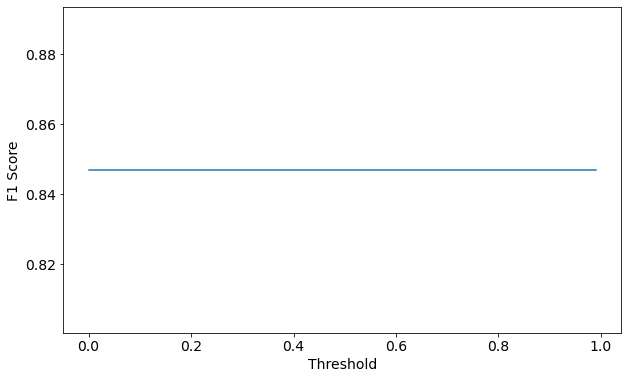

In [61]:
optimal_thresh = get_optimal_accuracy_thresh(y, lgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
accuracy_score(y, (lgb_oofs > optimal_thresh) * 1)

In [62]:
TARGET_COL = 'Crop_Damage'
target = y

## **Tuning LightGBM**

* Early Stopping: Stopping the model training, when the model starts to overfit
  * How do we know if model is overfitting ?
* HyperParameter Optimization.
  * Is random search the best way to go ?

**Simple Function to Run Gradient Boosting**

Let's make a simple function to call gradient boosting and get our oofs and predictions. Rather than copying and pasting the same code again and again/

In [63]:
def run_gradient_boosting(clf, fit_params, train, test, features):
  N_SPLITS = 5
  oofs = np.zeros(len(train_proc))
  preds = np.zeros((len(test_proc)))

  folds = StratifiedKFold(n_splits = N_SPLITS)

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train[TARGET_COL])):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

    ### Test Set
    X_test = test[features]

    scaler = StandardScaler()
    _ = scaler.fit(X_trn)

    X_trn = scaler.transform(X_trn)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    _ = clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], **fit_params)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    preds_val = clf.predict_proba(X_val)[:, 1]
    preds_test = clf.predict_proba(X_test)[:, 1]

    fold_score = accuracy_score(y_val, preds_val.round())
    print(f'\nAccuracy_score for validation set is {fold_score}')

    oofs[val_idx] = preds_val
    preds += preds_test / N_SPLITS


  oofs_score = accuracy_score(target, oofs.round())
  print(f'\n\nAccuracy_score for oofs is {oofs_score}')

  return oofs, preds

**Manual Tuning. Choosing Hyperparameters to Tune**


------------- Fold 1 -------------
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's multi_logloss: 0.416405
[200]	valid_0's multi_logloss: 0.415884
Early stopping, best iteration is:
[196]	valid_0's multi_logloss: 0.415833

Accuracy_score for validation set is 0.8437992347512941

------------- Fold 2 -------------
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's multi_logloss: 0.420959
[200]	valid_0's multi_logloss: 0.420097
[300]	valid_0's multi_logloss: 0.420151
Early stopping, best iteration is:
[245]	valid_0's multi_logloss: 0.419994

Accuracy_score for validation set is 0.8441368444744543

------------- Fold 3 -------------
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's multi_logloss: 0.419499
[200]	valid_0's multi_logloss: 0.418721
[300]	valid_0's multi_logloss: 0.419225
Early stopping, best iteration is:
[208]	valid_0's multi_logloss: 0.418701

Accuracy_score for validation set is 0.8423

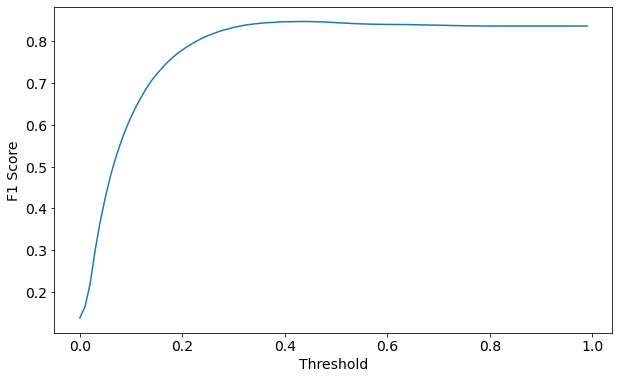

In [64]:
clf = LGBMClassifier(n_estimators = 1000,
                        learning_rate = 0.05,
                        colsample_bytree = 0.76,
                        )
fit_params = {'verbose': 100, 'early_stopping_rounds': 100}

lgb_oofs, lgb_preds = run_gradient_boosting(clf, fit_params, train_proc, test_proc, features)

optimal_thresh = get_optimal_accuracy_thresh(target, lgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = accuracy_score(target, (lgb_oofs > optimal_thresh) * 1)
print(f'Optimized F1 is {optimized_f1}')

**Submitting on the Leaderboard**

In [65]:
lgb_preds_rounded = (lgb_preds > optimal_thresh) * 1
#download_preds(y_pred_test)

**Tuning Learning Rate**

In [66]:
#LGBMClassifier?

In [67]:
# could tune learning rate, etc to check performance
clf = LGBMClassifier(n_estimators = 2000,
                     learning_rate = 0.01,
                     colsample_bytree = 0.65,
                     random_state = 2)

**Submitting on the Leaderboard**

In [68]:
lgb_preds_rounded = (lgb_preds > optimal_thresh) * 1
#download_preds(lgb_preds_rounded, file_name = 'hacklive_lgb_5_folds_learning_rate_tuned.csv')

Enough of LightGBM, lets now look at other libraries

## **CatBoost**

CatBoost is a high-performance open source library for gradient boosting on decision trees.

Features

* Great quality without parameter tuning: Reduce time spent on parameter tuning, because CatBoost provides great results with default parameters

* Categorical features support: Improve your training results with CatBoost that allows you to use non-numeric factors, instead of having to pre-process your data or spend time and effort turning it to numbers.

* Fast and scalable GPU version: Train your model on a fast implementation of gradient-boosting algorithm for GPU. Use a multi-card configuration for large datasets.

* Improved accuracy: Reduce overfitting when constructing your models with a novel gradient-boosting scheme.

* Fast prediction: Apply your trained model quickly and efficiently even to latency-critical tasks using CatBoost's model applier

https://catboost.ai/


------------- Fold 1 -------------
0:	learn: 1.0385034	test: 1.0382073	best: 1.0382073 (0)	total: 78.4ms	remaining: 3m 55s
200:	learn: 0.4211896	test: 0.4219296	best: 0.4219296 (200)	total: 5.69s	remaining: 1m 19s
400:	learn: 0.4137927	test: 0.4182765	best: 0.4182765 (400)	total: 11.1s	remaining: 1m 12s
600:	learn: 0.4091738	test: 0.4172550	best: 0.4172307 (593)	total: 16.5s	remaining: 1m 5s
800:	learn: 0.4054845	test: 0.4167726	best: 0.4167448 (793)	total: 21.9s	remaining: 1m
1000:	learn: 0.4019316	test: 0.4165517	best: 0.4165511 (999)	total: 27.4s	remaining: 54.7s
1200:	learn: 0.3989680	test: 0.4165770	best: 0.4164997 (1048)	total: 32.9s	remaining: 49.4s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.4164997256
bestIteration = 1048

Shrink model to first 1049 iterations.

Accuracy_score for validation set is 0.8440805761872608

------------- Fold 2 -------------
0:	learn: 1.0384548	test: 1.0383885	best: 1.0383885 (0)	total: 29.7ms	remaining: 1m 28s
200:	learn: 

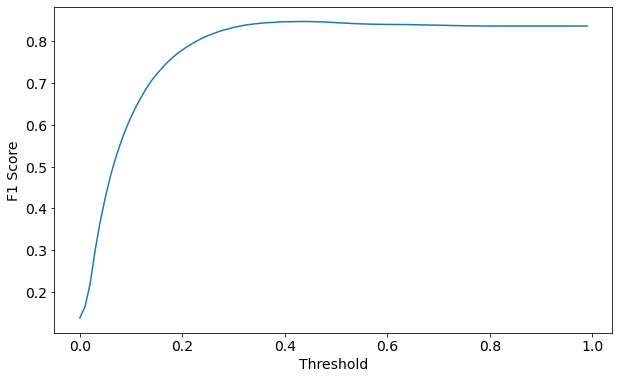

In [69]:
clf = CatBoostClassifier(n_estimators = 3000,
                       learning_rate = 0.05,
                       rsm = 0.4, ## Analogous to colsample_bytree
                       random_state=2054,
                       )

fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

cb_oofs, cb_preds = run_gradient_boosting(clf, fit_params, train_proc, test_proc, features)

optimal_thresh = get_optimal_accuracy_thresh(target, cb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = accuracy_score(target, (cb_oofs > optimal_thresh) * 1)
print(f'Optimized F1 is {optimized_f1}')

**Submitting on the Leaderboard**

In [71]:
cb_preds_rounded = (cb_preds > optimal_thresh) * 1
#download_preds(cb_preds_rounded)

**CatBoost: gives Improvement from 0.6585 to 0.6620 on LB**.

* Is catboost better then LightGBM ?
* Can catboost score be further improved ?
* Can LighGBM be tuned to give a better score than CatBoost ?

## **XGBoost**

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Hadoop, SGE, MPI) and can solve problems beyond billions of examples.

https://xgboost.readthedocs.io/en/latest/


------------- Fold 1 -------------
[0]	validation_0-merror:0.159408
Will train until validation_0-merror hasn't improved in 200 rounds.
[200]	validation_0-merror:0.153387
[400]	validation_0-merror:0.151868
[600]	validation_0-merror:0.15108
[800]	validation_0-merror:0.151474
Stopping. Best iteration:
[602]	validation_0-merror:0.150968


Accuracy_score for validation set is 0.8443619176232275

------------- Fold 2 -------------
[0]	validation_0-merror:0.156144
Will train until validation_0-merror hasn't improved in 200 rounds.
[200]	validation_0-merror:0.153275
[400]	validation_0-merror:0.152543
Stopping. Best iteration:
[365]	validation_0-merror:0.152262


Accuracy_score for validation set is 0.8437429664641009

------------- Fold 3 -------------
[0]	validation_0-merror:0.158395
Will train until validation_0-merror hasn't improved in 200 rounds.
[200]	validation_0-merror:0.154963
Stopping. Best iteration:
[168]	validation_0-merror:0.154288


Accuracy_score for validation set is 0.84188

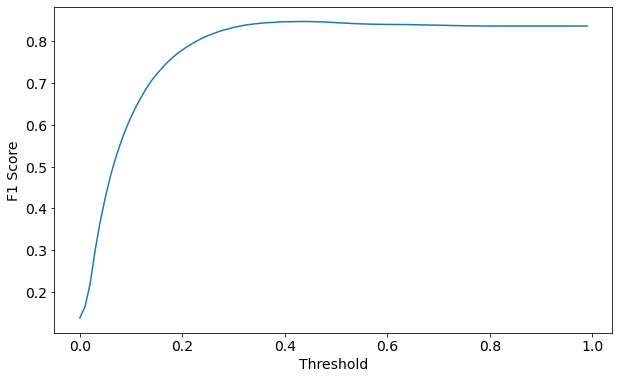

In [72]:
clf = XGBClassifier(n_estimators = 1000,
                    max_depth = 6,
                    learning_rate = 0.05,
                    colsample_bytree = 0.5,
                    random_state=1452,
                    )

fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

xgb_oofs, xgb_preds = run_gradient_boosting(clf, fit_params, train_proc, test_proc, features)

optimal_thresh = get_optimal_accuracy_thresh(target, xgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = accuracy_score(target, (xgb_oofs > optimal_thresh) * 1)
print(f'Optimized F1 is {optimized_f1}')

**Submitting on the Leaderboard**

In [73]:
xgb_preds_rounded = (xgb_preds > optimal_thresh) * 1
#download_preds(xgb_preds_rounded, file_name = 'hacklive_xgbb_5_folds.csv')

**Questions to think about XGBoost**

* Is XGBoost worse than LightGBM and CatBoost ?

* Can XGBoost be tuned more ?



# **Feature Engineering**

* What does a model know about a sample ?

* What the model does not know about the sample ?

* How do we provide that unknown information to the model ?


***Feature Engineering is one of the biggest difference maker in any ML competition.*** 

##Helper Functions

In [74]:
def join_df(train, test):

  df = pd.concat([train, test], axis=0).reset_index(drop = True)
  features = [col for col in df.columns if col not in ['ID','Crop_Damage']]

  return df, features

def split_df_and_get_features(df, train_nrows):

  train, test = df[:train_nrows].reset_index(drop = True), df[train_nrows:].reset_index(drop = True)
  features = [col for col in train.columns if col not in ['ID','Crop_Damage']]
  
  return train, test, features

In [75]:
df, features = join_df(train, test)

In [76]:
df.select_dtypes('object').columns.tolist()

['ID']

In [77]:
df, features = join_df(train, test)

### Label Encoding
df[cat_cols] = df[cat_cols].apply(lambda x: pd.factorize(x)[0])
#### No NaN filling required for gradient boosting

In [78]:
df.head()

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage
0,F00000001,188,0,0,0,0,0.0,0,0,0.0
1,F00000003,209,0,0,0,0,0.0,0,1,1.0
2,F00000004,257,0,0,0,0,0.0,0,1,1.0
3,F00000005,257,0,1,0,0,0.0,0,1,1.0
4,F00000006,342,0,0,0,0,0.0,0,1,1.0


## **Frequency Features**

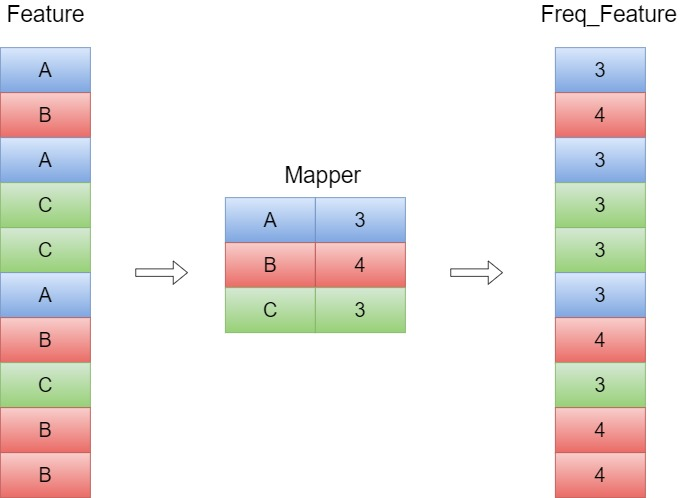

In [79]:
def get_frequency_features(df, cols):

  df[[c + '_freq' for c in cols]] = df[cols].apply(lambda x: x.map(x.value_counts()))
  
  return df

In [80]:
freq_cols = [c for c in df.columns if (train[c].nunique() > 10) and (train[c].nunique() < 50)]
freq_cols

['Number_Doses_Week']

In [81]:
df = get_frequency_features(df, freq_cols)
train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's multi_logloss: 0.418129
[400]	valid_0's multi_logloss: 0.416862
[600]	valid_0's multi_logloss: 0.417251
Early stopping, best iteration is:
[488]	valid_0's multi_logloss: 0.416748

Accuracy_score for validation set is 0.8430677470177808

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's multi_logloss: 0.424108
[400]	valid_0's multi_logloss: 0.422119
[600]	valid_0's multi_logloss: 0.422249
Early stopping, best iteration is:
[468]	valid_0's multi_logloss: 0.421903

Accuracy_score for validation set is 0.8435178933153274

------------- Fold 3 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's multi_logloss: 0.422037
[400]	valid_0's multi_logloss: 0.421155
[600]	valid_0's multi_logloss: 0.421397
Early stopping, best iteration is:
[471]	valid_0's multi_logloss: 0.420967

Acc

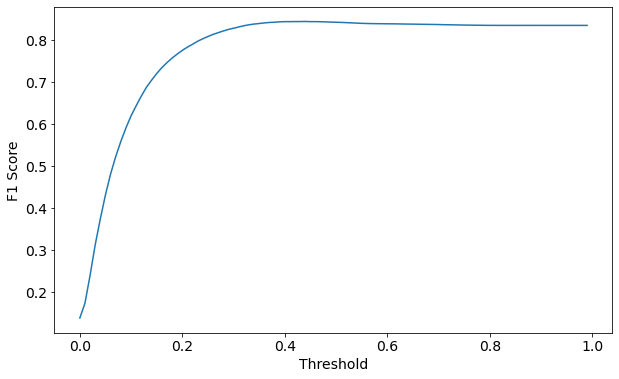

In [82]:
clf = LGBMClassifier(n_estimators = 2000,
                        learning_rate = 0.05,
                        colsample_bytree = 0.4,
                        reg_alpha = 1,
                        reg_lambda = 1
                        )
fit_params = {'verbose': 200, 'early_stopping_rounds': 200}
lgb_oofs, lgb_preds = run_gradient_boosting(clf, fit_params, train_proc, test_proc, features)

optimal_thresh = get_optimal_accuracy_thresh(target, lgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = accuracy_score(target, (lgb_oofs > optimal_thresh) * 1)
print(f'Optimized F1 is {optimized_f1}')

## **Interaction Features**

Can any two features be combined to make more sense in the given dataset ?

In [83]:
features = [col for col in train.columns if col not in ['ID','Crop_Damage']]
X = train[features]
y = train['Crop_Damage']

In [84]:
df = pd.concat([train, test]).reset_index(drop=True)
len(df.columns)

10

In [85]:
df.fillna(-999, inplace=True)

###Drop Features

In [86]:
ndf = df.copy()

# Crop_Type, Soil_Type, Season don't make much difference; except Pesticide_Use_Category
ndf.drop(columns=['Crop_Type', 'Soil_Type', 'Season'], inplace=True)
print(ndf.shape)

(148168, 7)


In [87]:
ntrain, nval = ndf[:train.shape[0]], ndf[train.shape[0]:]
nfeatures = [col for col in ndf.columns if col not in ['ID','Crop_Damage']]
print(ntrain.shape)

(88858, 7)


In [88]:
optimal_params = {'class_weight': {0: 1, 1: 1, 2: 1},
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 0.8,
 'max_leaf_nodes': 128,
 'min_samples_split': 2}

clf = DecisionTreeClassifier(random_state = 1, **optimal_params)

dt_oofs, dt_preds = run_clf_kfold(clf, ntrain, nval, nfeatures)


------------- Fold 1 -------------

Accuracy score for validation set is 0.8444744541976142

------------- Fold 2 -------------

Accuracy score for validation set is 0.8420549178483007

------------- Fold 3 -------------

Accuracy score for validation set is 0.8443056493360342

------------- Fold 4 -------------

Accuracy score for validation set is 0.843171459118789

------------- Fold 5 -------------

Accuracy score for validation set is 0.8422148444094311


Accuracy score for oofs is 0.8432442773863917


In [89]:
dt_preds_rounded = dt_preds
#download_preds(y_pred_test)

In [90]:
#ndf[df['Number_Weeks_Quit']!=0].head(10)
ndf.head(10)

,ID,Estimated_Insects_Count,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Crop_Damage
0,F00000001,188,1,0,0.0,0,0.0
1,F00000003,209,1,0,0.0,0,1.0
2,F00000004,257,1,0,0.0,0,1.0
3,F00000005,257,1,0,0.0,0,1.0
4,F00000006,342,1,0,0.0,0,1.0
5,F00000008,448,1,0,-999.0,0,1.0
6,F00000009,448,1,0,-999.0,0,1.0
7,F00000010,577,1,0,0.0,0,2.0
8,F00000012,731,1,0,0.0,0,0.0
9,F00000020,1132,1,0,0.0,0,2.0


### Integrate Features

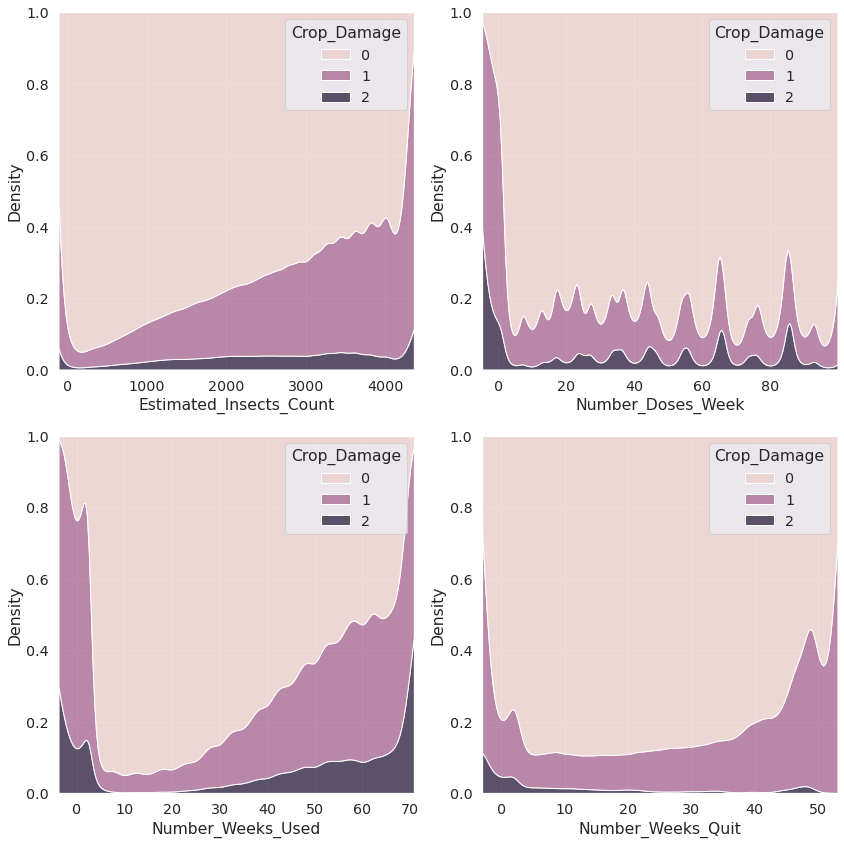

In [91]:
len(ndf.columns)

7

In [92]:
# deal with correlation of: 
#   Number_Weeks_Quit and Number_Weeks_Used, (-ve)
#   Number_Weeks_Used and Estimated_Insects_Count, (+ve) -> divide 
#   Number_Weeks_Quit and Estimated_Insects_Count (+ve)

#ndf['Weeks_Considered'] =  ndf['Number_Weeks_Quit'] * ndf['Number_Weeks_Used']
#ndf["Pesticide_Effect"] = ndf["Estimated_Insects_Count"] / ndf["Number_Weeks_Used"]
#ndf["Insect_revival"] = ndf["Estimated_Insects_Count"] / ndf["Number_Weeks_Quit"]
#ndf["Pesticide_Used"] = ndf["Number_Weeks_Used"] * ndf["Number_Doses_Week"]

ndf['Weeks_Considered'] =  ndf['Number_Weeks_Quit'] + ndf['Number_Weeks_Used']
#ndf["Pesticide_Effect"] = ndf["Estimated_Insects_Count"] / ndf["Number_Doses_Week"]
#ndf["Pesticide_Used"] = ndf["Number_Weeks_Used"] / ndf["Number_Doses_Week"]
ndf["Total_dose"] = ndf["Number_Weeks_Used"] * ndf["Number_Doses_Week"]

In [93]:
len(ndf.columns)

9

In [94]:
#ndf["Pesticide_Effect"][ndf["Pesticide_Effect"] == np.inf] = -9999
#ndf["Pesticide_Used"][ndf["Pesticide_Used"] == np.inf] = -9999

In [95]:
#from sklearn.preprocessing import LabelEncoder
#ndf['ID'] = LabelEncoder().fit_transform(ndf['ID'])
#nfeatures = [col for col in ndf.columns if col not in ['Crop_Damage']]

In [96]:
def split_df_and_get_features(ndf):
    ntrain, nval = ndf[:train.shape[0]], ndf[train.shape[0]:]
    nfeatures = [col for col in ndf.columns if col not in ['ID','Crop_Damage']]
    return ntrain, nval, nfeatures

In [97]:
ntrain, nval, nfeatures = split_df_and_get_features(ndf)

In [98]:
optimal_params = {'class_weight': {0: 1, 1: 1, 2: 1},
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 0.8,
 'max_leaf_nodes': 128,
 'min_samples_split': 2}

clf = DecisionTreeClassifier(random_state = 1, **optimal_params)

dt_oofs, dt_preds = run_clf_kfold(clf, ntrain, nval, nfeatures)


------------- Fold 1 -------------

Accuracy score for validation set is 0.8432928201665542

------------- Fold 2 -------------

Accuracy score for validation set is 0.8440243079000675

------------- Fold 3 -------------

Accuracy score for validation set is 0.8428426738690075

------------- Fold 4 -------------

Accuracy score for validation set is 0.8433965449327556

------------- Fold 5 -------------

Accuracy score for validation set is 0.8441843452816387


Accuracy score for oofs is 0.8435481329762092


In [99]:
dt_preds_rounded = dt_preds
#download_preds(y_pred_test)

In [100]:
len(dt_preds[dt_preds>1])

0

## **Grouping Features**

In [101]:
#df['mean_age_for_customer_on_month_and_day_of_month'] = df.groupby('month_and_day_of_month')['customer_age'].transform('mean')
#train_proc, test_proc, features = split_df_and_get_features(df, train.shape[0])

In [102]:
optimal_params = {'class_weight': {0: 1, 1: 1, 2: 1},
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 0.8,
 'max_leaf_nodes': 128,
 'min_samples_split': 2}

clf = DecisionTreeClassifier(random_state = 1, **optimal_params)
dt_oofs, dt_preds = run_clf_kfold(clf, ntrain, nval, nfeatures)


------------- Fold 1 -------------

Accuracy score for validation set is 0.8432928201665542

------------- Fold 2 -------------

Accuracy score for validation set is 0.8440243079000675

------------- Fold 3 -------------

Accuracy score for validation set is 0.8428426738690075

------------- Fold 4 -------------

Accuracy score for validation set is 0.8433965449327556

------------- Fold 5 -------------

Accuracy score for validation set is 0.8441843452816387


Accuracy score for oofs is 0.8435481329762092


# **Ensembling**




In statistics and machine learning, ensemble methods use multiple learning algorithms to obtain better predictive performance than could be obtained from any of the constituent learning algorithms alone.



* What are our best performing algorithms ?
* How do we combine these algorithms to get a better performance ?

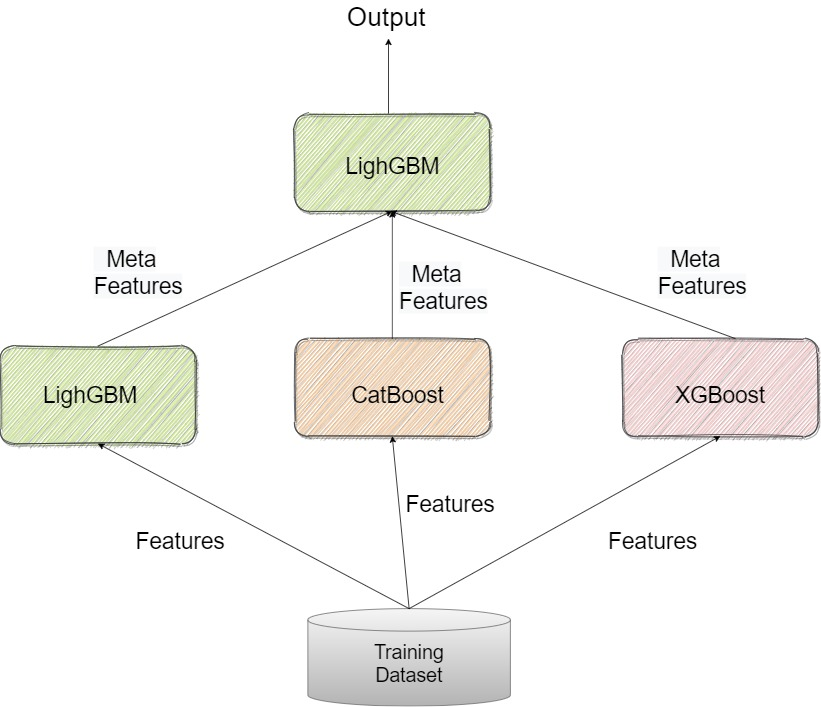

To read more about ensembling go here:

https://bit.ly/2SFgrnb

In [103]:
ID_COL = 'ID'
TARGET_COL = 'Crop_Damage'

In [104]:
train_new = train[[ID_COL, TARGET_COL]]
test_new = test[[ID_COL]]

train_new['lgb'] = lgb_oofs
test_new['lgb'] = lgb_preds

train_new['cb'] = cb_oofs
test_new['cb'] = cb_preds

train_new['xgb'] = xgb_oofs
test_new['xgb'] = xgb_preds

features = [c for c in train_new.columns if c not in [ID_COL, TARGET_COL]]

In [105]:
# Using decision tree instead of Gradient boosting as the GB algorithm is tweaked to round solution (which doesn't account for target value 2)
optimal_params = {'class_weight': {0: 1, 1: 1, 2: 1},
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 0.8,
 'max_leaf_nodes': 128,
 'min_samples_split': 2}

clf = DecisionTreeClassifier(random_state = 1, **optimal_params)

dt_oofs, dt_preds = run_clf_kfold(clf, train_new, test_new, features)


------------- Fold 1 -------------

Accuracy score for validation set is 0.8450371370695476

------------- Fold 2 -------------

Accuracy score for validation set is 0.8446432590591942

------------- Fold 3 -------------

Accuracy score for validation set is 0.8433490884537475

------------- Fold 4 -------------

Accuracy score for validation set is 0.8435653592932305

------------- Fold 5 -------------

Accuracy score for validation set is 0.8428901018513308


Accuracy score for oofs is 0.8438970042089626


In [106]:
dt_preds_rounded = dt_preds
#download_preds(y_pred_test)

# **Making Final Submission**

## Best CV or Best LB ?
Go for better Cross Validation score, as LeaderBoard score can be misleading as it shows only public score and not private score during competition

## What else can I try:

**Feature Engineering**

* Try adding/removing features, and see which features improve/degrade performance.

* Try adding more grouping, interaction and frequency features.

* Read other solutions.



**Ensembling**

* Try adding other tree based models like RandomForest, ExtraTrees, AdaBoos.

* Try adding Neural Networks to the ensemble model.
